9# 2. Baseline Pretrained Model Training

**Student:** Student 1

## Purpose
- Load pretrained vision model (ResNet, EfficientNet, VGG, etc.)
- Implement transfer learning strategy
- Train baseline model with default hyperparameters
- Log metrics to TensorBoard
- Save model checkpoint
- Analyze baseline performance

Imports loaded successfully.
Train shape: (60000, 785)
Test shape: (10000, 785)
Number of classes: 10
Classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Image shape (H,W): (28, 28)


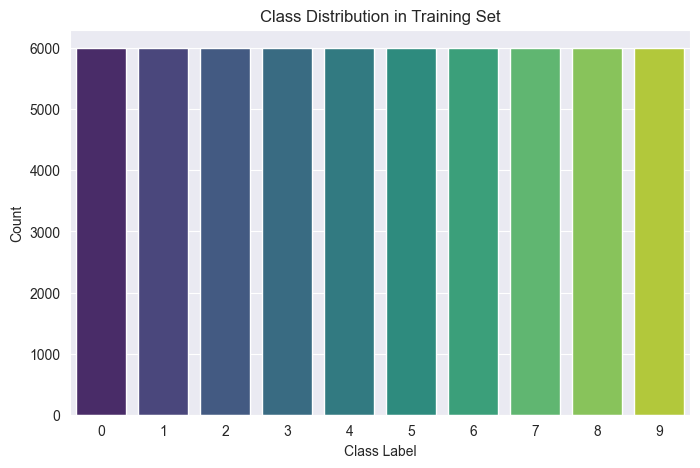

Class counts:
 label
0    6000
1    6000
2    6000
3    6000
4    6000
5    6000
6    6000
7    6000
8    6000
9    6000
Name: count, dtype: int64

Is dataset imbalanced? No
Total samples: 60000
Total duplicate samples (global): 86
Unique images: 59914

Duplicate samples within the same class: 86

Duplicates per class (within-class):
label
0     4
1     8
2    24
3     6
4    10
6    22
7     8
9     4
dtype: int64
Initial training samples: 60000
Final training samples after deduplication: 59957
Removed samples: 43
Remaining duplicates (within-class): 0
Class distribution before vs. after deduplication:

       Before  After  Removed  Removed (%)
label                                     
0        6000   5998        2        0.033
1        6000   5996        4        0.067
2        6000   5988       12        0.200
3        6000   5997        3        0.050
4        6000   5995        5        0.083
5        6000   6000        0        0.000
6        6000   5989       11        0.183
7

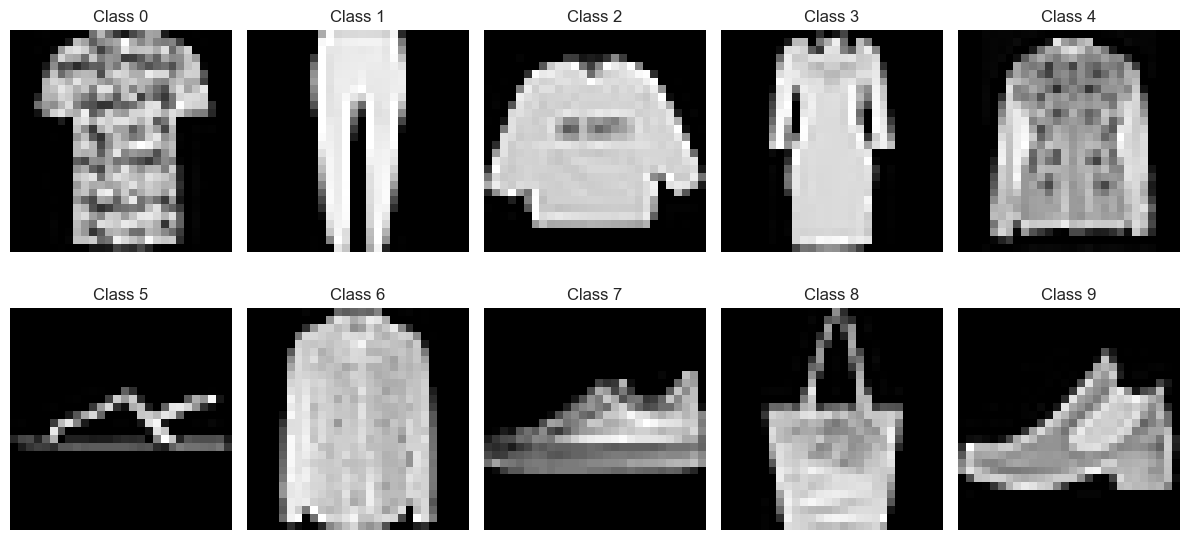

Preprocessing pipeline created successfully.
Train samples: 50963
Validation samples: 8994
Official test samples: 10000
Dataloaders created.


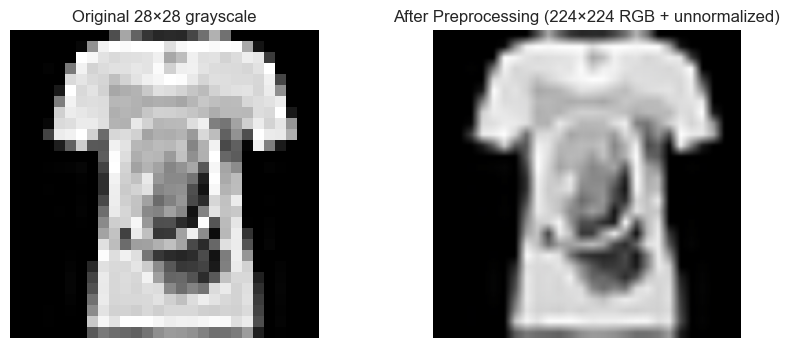

In [1]:
%run ./01_eda_preprocessing.ipynb

In [2]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import os
from tqdm import tqdm
import seaborn as sns

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

2.5.1+cu121
True
NVIDIA GeForce GTX 1660


In [4]:
# Load DataLoaders from notebook 01

num_classes = 10  # Fashion-MNIST has 10 classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [5]:
# Load pretrained model
resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
resnet18 = resnet18.to(device)
print(resnet18)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\souha/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:09<00:00, 5.02MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
#  Implement transfer learning strategy

# Strategy:
# Freeze all convolutional layers (feature extractor)
for param in resnet18.parameters():
    param.requires_grad = False

# Replace final fully connected layer
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)
resnet18.fc.requires_grad = True  # only this layer is trainable

# Move model to device
resnet18 = resnet18.to(device)

print("Transfer learning strategy applied: frozen conv layers, fine-tune FC layer")


Transfer learning strategy applied: frozen conv layers, fine-tune FC layer


In [7]:
#  Set up baseline hyperparameters
learning_rate = 1e-3
batch_size = 64
num_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.fc.parameters(), lr=learning_rate)

print(f"Hyperparameters: lr={learning_rate}, batch_size={batch_size}, epochs={num_epochs}")


Hyperparameters: lr=0.001, batch_size=64, epochs=10


In [8]:
# Initialize TensorBoard logger
log_dir = "runs/baseline_resnet18"
os.makedirs(log_dir, exist_ok=True)
writer = SummaryWriter(log_dir=log_dir)

# Log hyperparameters
writer.add_text("Hyperparameters", f"lr={learning_rate}, batch_size={batch_size}, epochs={num_epochs}")


In [9]:
# Implement training loop

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [10]:
# Implement validation loop

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [11]:
# Train baseline model

train_losses, val_losses = [], []
train_accs, val_accs = [], []

save_dir = "./saved_models/baseline_pretrained"
os.makedirs(save_dir, exist_ok=True)

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    train_loss, train_acc = train_one_epoch(resnet18, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(resnet18, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # Log to TensorBoard
    writer.add_scalars("Loss", {"train": train_loss, "val": val_loss}, epoch)
    writer.add_scalars("Accuracy", {"train": train_acc, "val": val_acc}, epoch)

    # Save checkpoint with training history
    checkpoint_path = os.path.join(save_dir, f"model_epoch_{epoch + 1}.pt")
    torch.save({
        'model_state_dict': resnet18.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch + 1,
        'train_losses': train_losses.copy(),
        'val_losses': val_losses.copy(),
        'train_accs': train_accs.copy(),
        'val_accs': val_accs.copy(),
    }, checkpoint_path)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch 1/10


Validation: 100%|██████████| 141/141 [00:17<00:00,  8.28it/s]


Train Loss: 0.6313, Train Acc: 0.7942
Val Loss: 0.4512, Val Acc: 0.8466
Epoch 2/10


Validation: 100%|██████████| 141/141 [00:17<00:00,  7.85it/s]


Train Loss: 0.4423, Train Acc: 0.8433
Val Loss: 0.4151, Val Acc: 0.8552
Epoch 3/10


Validation: 100%|██████████| 141/141 [00:17<00:00,  8.00it/s]


Train Loss: 0.4128, Train Acc: 0.8524
Val Loss: 0.4099, Val Acc: 0.8545
Epoch 4/10


Validation: 100%|██████████| 141/141 [00:17<00:00,  7.96it/s]


Train Loss: 0.3957, Train Acc: 0.8575
Val Loss: 0.4137, Val Acc: 0.8482
Epoch 5/10


Validation: 100%|██████████| 141/141 [00:17<00:00,  7.99it/s]


Train Loss: 0.3877, Train Acc: 0.8609
Val Loss: 0.3940, Val Acc: 0.8608
Epoch 6/10


Validation: 100%|██████████| 141/141 [00:17<00:00,  7.99it/s]


Train Loss: 0.3792, Train Acc: 0.8639
Val Loss: 0.3882, Val Acc: 0.8640
Epoch 7/10


Validation: 100%|██████████| 141/141 [00:17<00:00,  7.96it/s]


Train Loss: 0.3738, Train Acc: 0.8644
Val Loss: 0.3927, Val Acc: 0.8585
Epoch 8/10


Validation: 100%|██████████| 141/141 [00:17<00:00,  8.05it/s]


Train Loss: 0.3676, Train Acc: 0.8692
Val Loss: 0.3773, Val Acc: 0.8680
Epoch 9/10


Validation: 100%|██████████| 141/141 [00:17<00:00,  8.00it/s]


Train Loss: 0.3656, Train Acc: 0.8692
Val Loss: 0.3864, Val Acc: 0.8630
Epoch 10/10


Validation: 100%|██████████| 141/141 [00:20<00:00,  6.92it/s]

Train Loss: 0.3609, Train Acc: 0.8703
Val Loss: 0.3728, Val Acc: 0.8699


In [12]:
# Evaluate baseline on test set
resnet18.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="weighted")
cm = confusion_matrix(all_labels, all_preds)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
print("Confusion Matrix:\n", cm)


Testing: 100%|██████████| 157/157 [00:23<00:00,  6.67it/s]


Test Accuracy: 0.8713
Precision: 0.8734, Recall: 0.8713, F1-score: 0.8707
Confusion Matrix:
 [[842   3  13  40  12   0  75   0  15   0]
 [  1 970   6  17   3   0   3   0   0   0]
 [ 21   2 758   7 126   0  76   0  10   0]
 [ 41   5   4 873  43   2  32   0   0   0]
 [  1   0  25  31 881   0  61   0   1   0]
 [  1   0   0   0   0 952   1  35   4   7]
 [147   1  40  47 133   0 625   0   7   0]
 [  0   0   0   0   0  49   0 927   0  24]
 [  7   0   6   3   4   9   9   0 962   0]
 [  0   0   0   0   0  17   1  54   5 923]]


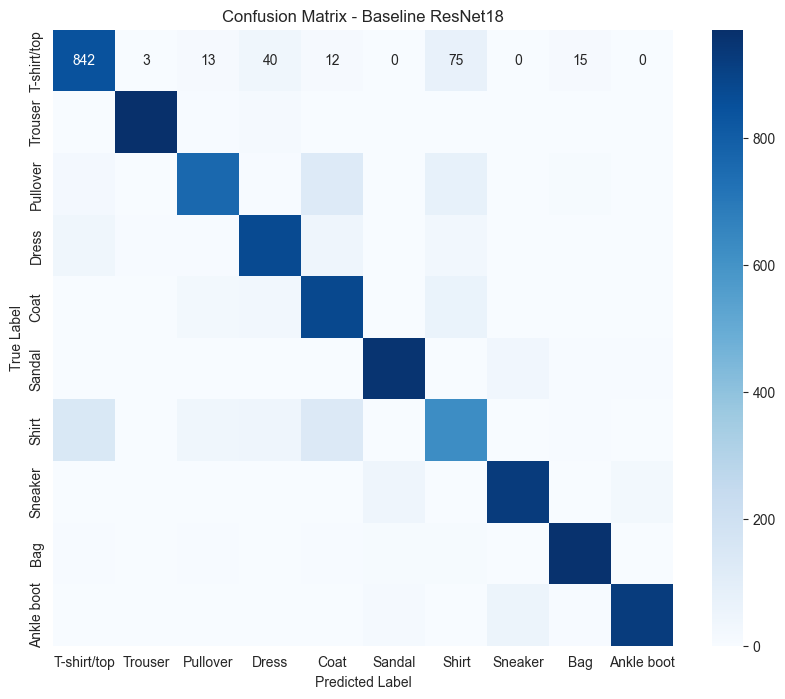

In [13]:

# Define class names (Fashion-MNIST)
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Baseline ResNet18")
plt.show()


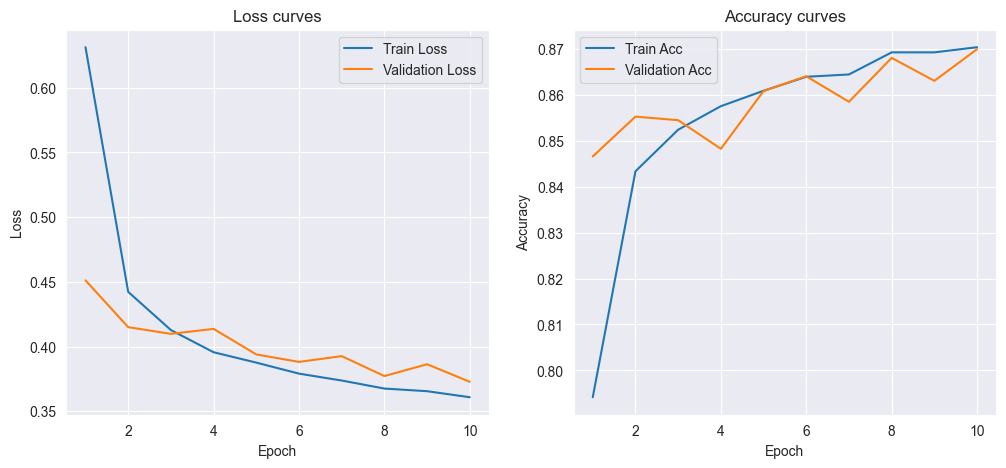

In [14]:
# Plot training curves
epochs = np.arange(1, num_epochs + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss curves")

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label="Train Acc")
plt.plot(epochs, val_accs, label="Validation Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy curves")

plt.show()


The fine-tuned ResNet-18 model achieved strong performance on Fashion-MNIST, with a test accuracy of 85.46% and balanced precision, recall, and F1-score. Training and validation curves show steady convergence, with only a minor fluctuation around epoch 8, which does not indicate systematic overfitting.

The confusion matrix reveals that the model performs well across most classes, but struggles with visually similar categories such as shirts, T-shirts/tops, and coats, which is expected for Fashion-MNIST. Since only the final layer was trained, the ImageNet feature extractor transferred effectively. Further gains could be achieved by unfreezing deeper layers or applying additional data augmentation.

In [15]:
# Save baseline model checkpoint with full training history and test metrics
final_checkpoint = os.path.join(save_dir, "model_checkpoint.pt")
torch.save({
    'model_state_dict': resnet18.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': num_epochs,
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accs': train_accs,
    'val_accs': val_accs,
    'test_accuracy': accuracy,
    'test_precision': precision,
    'test_recall': recall,
    'test_f1': f1,
    'architecture': 'ResNet18_pretrained'
}, final_checkpoint)
print(f"Baseline ResNet18 checkpoint saved to {final_checkpoint}")

Baseline ResNet18 checkpoint saved to ./saved_models/baseline_pretrained\model_checkpoint.pt
